<a href="https://colab.research.google.com/github/Youstina-Raouf/DataOrbitProject/blob/main/latest_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Notebook 02 — Modeling (Provider-level Fraud Detection)

#Content:
#- Load provider-level features created in Notebook 1
#- Train / test split (stratified)
#- Preprocessing (numeric scaling, categorical encoding)
#- Train baseline and candidate models: Logistic Regression, Random Forest, Gradient Boosting (sklearn), XGBoost
#- Evaluate models (Precision, Recall, F1, ROC-AUC, PR-AUC)
#- Compare models in a table
#- Precision-Recall and ROC plots for each model
#- Feature importance (XGBoost & Random Forest)
#- Threshold tuning (choose operating threshold based on F1 / business tradeoff)
#- Save final model


In [ ]:
# Cell: imports and path
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report
)
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay

from xgboost import XGBClassifier
import joblib, os

# Path to provider features CSV (update if different)
DATA_PATH = Path("/content/provider_features_latest.csv")

In [ ]:
# Load dataset (keep Provider ID for error analysis)
# Fix: The file name in DATA_PATH was incorrect. Correcting it to 'provider_features.csv'.
DATA_PATH = Path("/content/provider_features_latest.csv")
df_full = pd.read_csv(DATA_PATH)

# If "Provider" exists keep it; if not, create a Provider index
if 'Provider' not in df_full.columns:
    df_full['Provider'] = df_full.index.astype(str)

# Inspect
print("Shape:", df_full.shape)
print("Columns:", df_full.columns.tolist())
df_full.head()

Shape: (4731, 15)
Columns: ['Provider', 'TotalClaim', 'AvgClaim', 'MaxClaim', 'StdClaim', 'NumClaims', 'UniquePatients', 'InpatientClaims', 'OutpatientClaims', 'ClaimPerPatient', 'AvgClaimPerPatient', 'InpatientRatio', 'OutpatientRatio', 'PotentialFraud', 'fraud_label']


,Provider,TotalClaim,AvgClaim,MaxClaim,StdClaim,NumClaims,UniquePatients,InpatientClaims,OutpatientClaims,ClaimPerPatient,AvgClaimPerPatient,InpatientRatio,OutpatientRatio,PotentialFraud,fraud_label
0,PRV51001,99120,11013.333333,42000,16351.256832,9,9,5,4,1.000000,11013.333333,0.555555,0.444444,No,0
1,PRV51003,582790,7668.289474,57000,8376.464551,76,67,62,14,1.134328,8698.358209,0.815789,0.184211,Yes,1
2,PRV51004,6990,332.857143,2100,521.307422,21,21,0,21,1.000000,332.857143,0.000000,1.000000,No,0
3,PRV51005,51970,279.408602,3300,563.419267,186,67,0,186,2.776119,775.671642,0.000000,1.000000,Yes,1
4,PRV51007,20190,1682.500000,10000,3180.903602,12,10,3,9,1.200000,2019.000000,0.250000,0.750000,No,0


In [ ]:




# Drop leakage columns if present (PotentialFraud is label duplicate)
leak_cols = [c for c in ['PotentialFraud'] if c in df_full.columns]
df = df_full.drop(columns=leak_cols)

# Keep Provider column separately for later mapping
provider_ids = df['Provider'].copy()

# Target
if 'fraud_label' not in df.columns:
    raise ValueError("fraud_label column not found in dataset. Make sure Notebook 1 export has fraud_label.")

X = df.drop(columns=['fraud_label'])
y = df['fraud_label'].astype(int)

# Drop Provider from X (we won't use it as a feature)
if 'Provider' in X.columns:
    X = X.drop(columns=['Provider'])

print("X shape:", X.shape, "y distribution:\n", y.value_counts(normalize=True))


X shape: (4731, 12) y distribution:
 fraud_label
0    0.893257
1    0.106743
Name: proportion, dtype: float64


In [ ]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test, prov_train, prov_test = train_test_split(
    X, y, provider_ids, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print("Train y dist:\n", y_train.value_counts(normalize=True))
print("Test y dist:\n", y_test.value_counts(normalize=True))


Train y dist:
 fraud_label
0    0.893235
1    0.106765
Name: proportion, dtype: float64
Test y dist:
 fraud_label
0    0.893347
1    0.106653
Name: proportion, dtype: float64


In [ ]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder='drop')

Numeric features: ['TotalClaim', 'AvgClaim', 'MaxClaim', 'StdClaim', 'NumClaims', 'UniquePatients', 'InpatientClaims', 'OutpatientClaims', 'ClaimPerPatient', 'AvgClaimPerPatient', 'InpatientRatio', 'OutpatientRatio']
Categorical features: []


In [ ]:
# Handling class imbalance

#We will:
#- Use `class_weight='balanced'` for Logistic Regression and RandomForest where supported.
#- For XGBoost we set `scale_pos_weight = (#neg / #pos)` to balance gradient updates.
#- We avoid oversampling in this notebook to keep explainability and avoid data leakage; oversampling (SMOTE) can be considered later if recall needs improvement.


In [ ]:
# Helper function to evaluate model and return metrics & probs
def evaluate_model(pipeline, X_test, y_test):
    probs = pipeline.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)
    metrics = {
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_test, probs),
        'pr_auc': average_precision_score(y_test, probs)
    }
    return metrics, probs, preds


In [ ]:
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))
])

lr_pipeline.fit(X_train, y_train)
lr_metrics, lr_probs, lr_preds = evaluate_model(lr_pipeline, X_test, y_test)

print("Logistic Regression metrics:", lr_metrics)


Logistic Regression metrics: {'precision': 0.445, 'recall': 0.8811881188118812, 'f1': 0.5913621262458472, 'roc_auc': np.float64(0.9344907895044825), 'pr_auc': np.float64(0.7077012509634365)}


In [ ]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_metrics, rf_probs, rf_preds = evaluate_model(rf_pipeline, X_test, y_test)

print("Random Forest metrics:", rf_metrics)


Random Forest metrics: {'precision': 0.6615384615384615, 'recall': 0.42574257425742573, 'f1': 0.5180722891566265, 'roc_auc': np.float64(0.9240046345060038), 'pr_auc': np.float64(0.6670239088359067)}


In [ ]:
gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

gb_pipeline.fit(X_train, y_train)
gb_metrics, gb_probs, gb_preds = evaluate_model(gb_pipeline, X_test, y_test)

print("Gradient Boosting (sklearn) metrics:", gb_metrics)


Gradient Boosting (sklearn) metrics: {'precision': 0.6944444444444444, 'recall': 0.49504950495049505, 'f1': 0.5780346820809249, 'roc_auc': np.float64(0.9308686187767712), 'pr_auc': np.float64(0.6554670067119571)}


In [ ]:
# compute scale_pos_weight for XGBoost
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=450,
        learning_rate=0.02,
        max_depth=4,
        min_child_weight=2,
        subsample=0.85,
        colsample_bytree=0.85,
        gamma=0.3,
        reg_alpha=0.3,
        reg_lambda=1.0,
        scale_pos_weight=scale_pos,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_metrics, xgb_probs, xgb_preds = evaluate_model(xgb_pipeline, X_test, y_test)

print("XGBoost metrics:", xgb_metrics)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:57:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost metrics: {'precision': 0.4606741573033708, 'recall': 0.8118811881188119, 'f1': 0.5878136200716846, 'roc_auc': np.float64(0.9321501299066077), 'pr_auc': np.float64(0.698344311957324)}


In [ ]:
# Collect metrics
results = pd.DataFrame({
    'model': ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'XGBoost'],
    'precision': [lr_metrics['precision'], rf_metrics['precision'], gb_metrics['precision'], xgb_metrics['precision']],
    'recall': [lr_metrics['recall'], rf_metrics['recall'], gb_metrics['recall'], xgb_metrics['recall']],
    'f1': [lr_metrics['f1'], rf_metrics['f1'], gb_metrics['f1'], xgb_metrics['f1']],
    'roc_auc': [lr_metrics['roc_auc'], rf_metrics['roc_auc'], gb_metrics['roc_auc'], xgb_metrics['roc_auc']],
    'pr_auc': [lr_metrics['pr_auc'], rf_metrics['pr_auc'], gb_metrics['pr_auc'], xgb_metrics['pr_auc']]
})

results = results.sort_values(by='pr_auc', ascending=False).reset_index(drop=True)
results.style.format("{:.4f}", subset=['precision','recall','f1','roc_auc','pr_auc'])


,model,precision,recall,f1,roc_auc,pr_auc
0,LogisticRegression,0.4450,0.8812,0.5914,0.9345,0.7077
1,XGBoost,0.4607,0.8119,0.5878,0.9322,0.6983
2,RandomForest,0.6615,0.4257,0.5181,0.9240,0.6670
3,GradientBoosting,0.6944,0.4950,0.5780,0.9309,0.6555


In [ ]:
# Model Comparison Summary
import pandas as pd

model_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost", "Gradient Boosting", "Random Forest"],
    "Precision": [lr_metrics['precision'], xgb_metrics['precision'], gb_metrics['precision'], rf_metrics['precision']],
    "Recall": [lr_metrics['recall'], xgb_metrics['recall'], gb_metrics['recall'], rf_metrics['recall']],
    "F1-score": [lr_metrics['f1'], xgb_metrics['f1'], gb_metrics['f1'], rf_metrics['f1']],
    "ROC-AUC": [lr_metrics['roc_auc'], xgb_metrics['roc_auc'], gb_metrics['roc_auc'], rf_metrics['roc_auc']],
    "PR-AUC": [lr_metrics['pr_auc'], xgb_metrics['pr_auc'], gb_metrics['pr_auc'], rf_metrics['pr_auc']],
    "Notes": ["Selected model (PR-AUC)", "Comparison / interpretability", "Sklearn GB", "Tuned RF"]
})

model_summary = model_summary.sort_values(by="PR-AUC", ascending=False).reset_index(drop=True)
model_summary.style.format("{:.4f}", subset=['Precision','Recall','F1-score','ROC-AUC','PR-AUC'])



,Model,Precision,Recall,F1-score,ROC-AUC,PR-AUC,Notes
0,Logistic Regression,0.4450,0.8812,0.5914,0.9345,0.7077,Selected model (PR-AUC)
1,XGBoost,0.4607,0.8119,0.5878,0.9322,0.6983,Comparison / interpretability
2,Random Forest,0.6615,0.4257,0.5181,0.9240,0.6670,Tuned RF
3,Gradient Boosting,0.6944,0.4950,0.5780,0.9309,0.6555,Sklearn GB


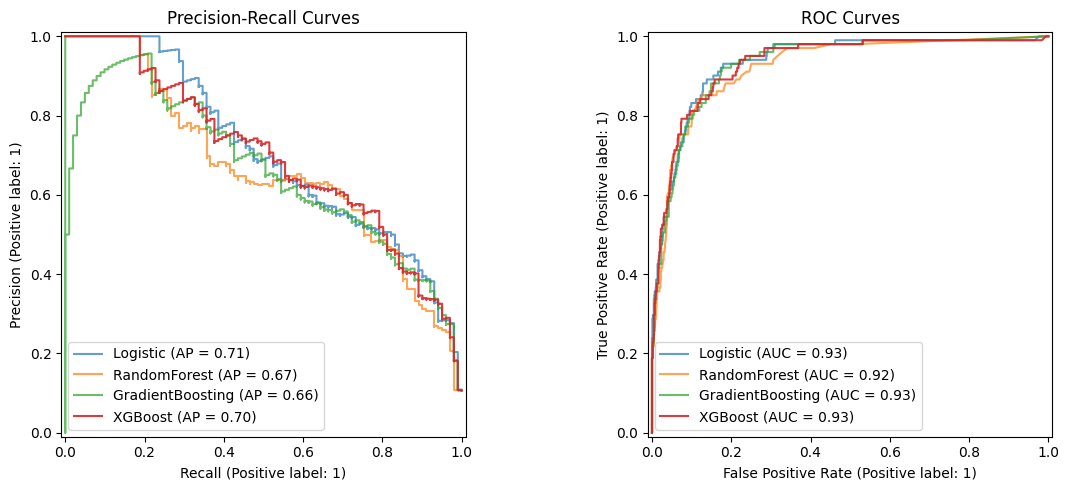

In [ ]:
plt.figure(figsize=(12,5))

# Subplot 1: Precision-Recall
ax1 = plt.subplot(1,2,1)
PrecisionRecallDisplay.from_predictions(y_test, lr_probs, name='Logistic', alpha=0.7, ax=ax1)
PrecisionRecallDisplay.from_predictions(y_test, rf_probs, name='RandomForest', alpha=0.7, ax=ax1)
PrecisionRecallDisplay.from_predictions(y_test, gb_probs, name='GradientBoosting', alpha=0.7, ax=ax1)
PrecisionRecallDisplay.from_predictions(y_test, xgb_probs, name='XGBoost', alpha=0.9, ax=ax1)
ax1.set_title("Precision-Recall Curves")
ax1.legend()

# Subplot 2: ROC
ax2 = plt.subplot(1,2,2)
RocCurveDisplay.from_predictions(y_test, lr_probs, name='Logistic', alpha=0.7, ax=ax2)
RocCurveDisplay.from_predictions(y_test, rf_probs, name='RandomForest', alpha=0.7, ax=ax2)
RocCurveDisplay.from_predictions(y_test, gb_probs, name='GradientBoosting', alpha=0.7, ax=ax2)
RocCurveDisplay.from_predictions(y_test, xgb_probs, name='XGBoost', alpha=0.9, ax=ax2)
ax2.set_title("ROC Curves")
ax2.legend()

plt.tight_layout()
plt.show()


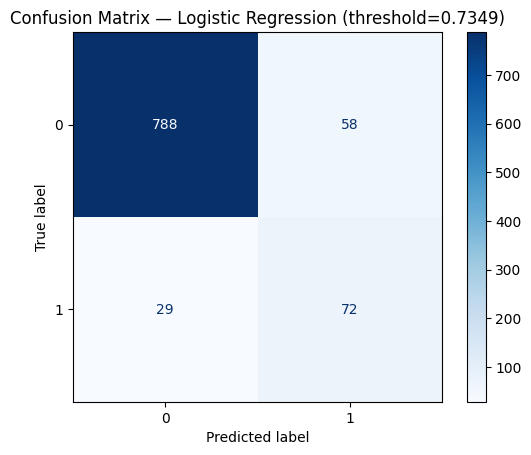

Classification report (chosen threshold):
              precision    recall  f1-score   support

           0     0.9645    0.9314    0.9477       846
           1     0.5538    0.7129    0.6234       101

    accuracy                         0.9081       947
   macro avg     0.7592    0.8222    0.7855       947
weighted avg     0.9207    0.9081    0.9131       947



In [ ]:
# --- Select final model based on PR-AUC ---
# Logistic Regression is now the "best" for PR-AUC selection
final_model = lr_pipeline
final_probs = lr_probs
final_preds = lr_preds


# Keep XGBoost for comparison / feature importance
xgb_model_for_analysis = xgb_pipeline
# Evaluate thresholds on LR predictions
thresholds = np.linspace(0.001, 0.9, 50)
rows = []
for t in thresholds:
    preds_t = (lr_probs >= t).astype(int)
    rows.append({
        'threshold': t,
        'precision': precision_score(y_test, preds_t, zero_division=0),
        'recall': recall_score(y_test, preds_t, zero_division=0),
        'f1': f1_score(y_test, preds_t, zero_division=0)
    })

th_df = pd.DataFrame(rows)
best_row = th_df.iloc[th_df['f1'].idxmax()]
chosen_threshold = float(best_row['threshold'])
pred_chosen = (lr_probs >= chosen_threshold).astype(int)

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_chosen, cmap="Blues")
plt.title(f"Confusion Matrix — Logistic Regression (threshold={chosen_threshold:.4f})")
plt.show()

print("Classification report (chosen threshold):")
print(classification_report(y_test, pred_chosen, digits=4, zero_division=0))


In [ ]:
# Extract feature names after ColumnTransformer + OneHotEncoder
# Works with sklearn >= 1.0 for get_feature_names_out on transformers

# numeric names
num_names = numeric_features

# categorical one-hot names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_cols = categorical_features
try:
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
except:
    # fallback
    ohe_names = []
feature_names = num_names + ohe_names
len(feature_names)


12

,0
AvgClaim,-1.135438
AvgClaimPerPatient,1.062116
TotalClaim,1.053049
OutpatientClaims,0.788205
NumClaims,0.648829
MaxClaim,0.461223
UniquePatients,-0.396261
InpatientRatio,0.284030
OutpatientRatio,-0.283993
StdClaim,0.280734


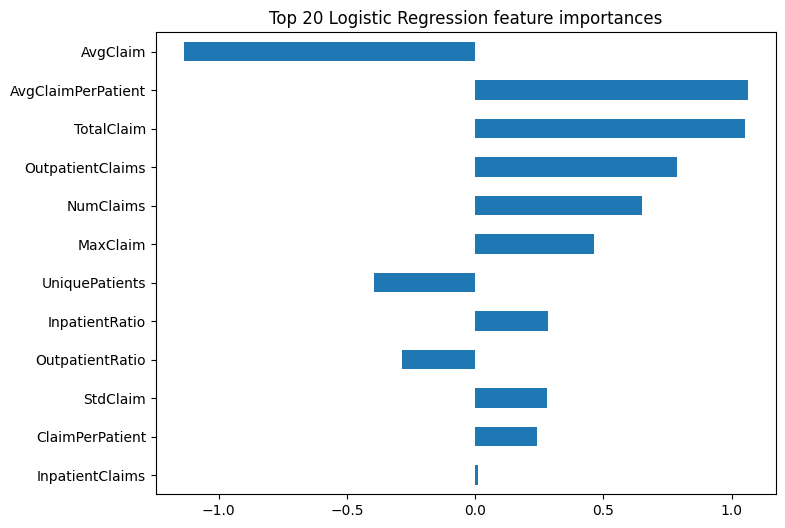

In [ ]:
# Logistic Regression feature importance
lr_model = final_model.named_steps['clf']  # LogisticRegression
try:
    fi_lr = pd.Series(lr_model.coef_[0], index=feature_names).sort_values(key=abs, ascending=False)
    display(fi_lr.head(25))
except Exception as e:
    print("Could not map Logistic Regression coefficients to feature names:", e)

# Plot top 20 absolute importance
plt.figure(figsize=(8,6))
fi_lr.head(20).sort_values(key=abs).plot(kind='barh')
plt.title("Top 20 Logistic Regression feature importances")
plt.show()


In [ ]:
# Compute predictions with chosen threshold (0.5 initially)
threshold = 0.5
final_probs = final_model.predict_proba(X_test)[:,1]
pred_thresh = (final_probs >= threshold).astype(int)

# Map back to provider IDs for error analysis
errors = pd.DataFrame({
    'Provider': prov_test.values,
    'y_true': y_test.values,
    'prob': final_probs,
    'pred_05': pred_thresh
})

false_positives = errors[(errors['y_true'] == 0) & (errors['pred_05'] == 1)]
false_negatives = errors[(errors['y_true'] == 1) & (errors['pred_05'] == 0)]

print("False positives (count):", len(false_positives))
print(false_positives.head())
print("False negatives (count):", len(false_negatives))
print(false_negatives.head())


False positives (count): 111
    Provider  y_true      prob  pred_05
9   PRV56686       0  0.742450        1
10  PRV51430       0  0.567689        1
24  PRV56574       0  0.634418        1
26  PRV55213       0  0.661559        1
29  PRV52565       0  0.553345        1
False negatives (count): 12
     Provider  y_true      prob  pred_05
86   PRV54743       1  0.231951        0
201  PRV55959       1  0.216719        0
341  PRV53106       1  0.233110        0
468  PRV55895       1  0.048865        0
541  PRV52860       1  0.375933        0


In [ ]:
# Evaluate metrics across thresholds
thresholds = np.linspace(0.001, 0.5, 50)
rows = []
for t in thresholds:
    preds_t = (final_probs >= t).astype(int)
    rows.append({
        'threshold': t,
        'precision': precision_score(y_test, preds_t, zero_division=0),
        'recall': recall_score(y_test, preds_t, zero_division=0),
        'f1': f1_score(y_test, preds_t, zero_division=0)
    })

th_df = pd.DataFrame(rows)
best_row = th_df.iloc[th_df['f1'].idxmax()]
best_row


,49
threshold,0.500000
precision,0.445000
recall,0.881188
f1,0.591362


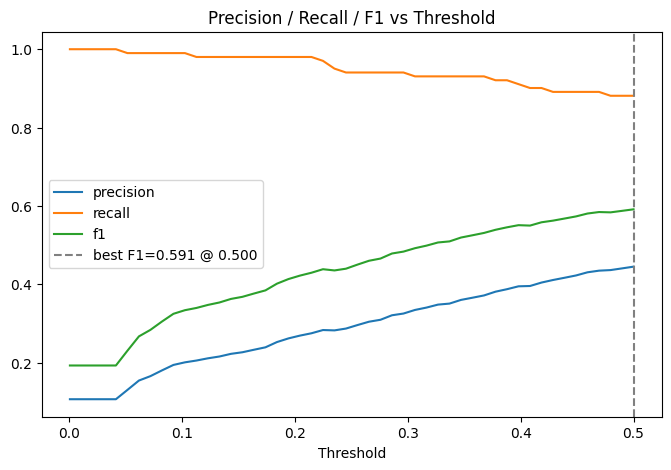

Suggested threshold (max F1): 0.5


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(th_df['threshold'], th_df['precision'], label='precision')
plt.plot(th_df['threshold'], th_df['recall'], label='recall')
plt.plot(th_df['threshold'], th_df['f1'], label='f1')
plt.axvline(best_row['threshold'], color='gray', linestyle='--', label=f"best F1={best_row['f1']:.3f} @ {best_row['threshold']:.3f}")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision / Recall / F1 vs Threshold")
plt.show()

print("Suggested threshold (max F1):", best_row['threshold'])


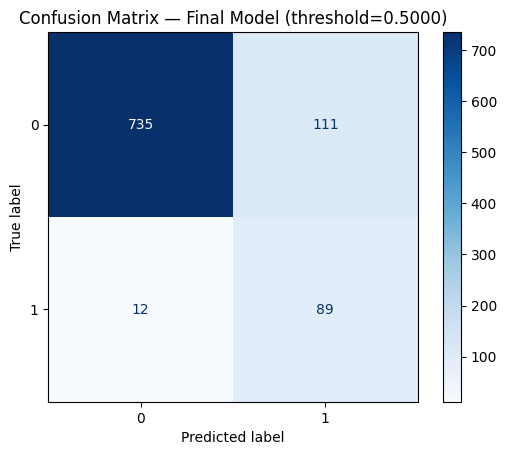

Classification report (chosen threshold):
              precision    recall  f1-score   support

           0     0.9839    0.8688    0.9228       846
           1     0.4450    0.8812    0.5914       101

    accuracy                         0.8701       947
   macro avg     0.7145    0.8750    0.7571       947
weighted avg     0.9265    0.8701    0.8874       947



In [ ]:
chosen_threshold = float(best_row['threshold'])
pred_chosen = (final_probs >= chosen_threshold).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, pred_chosen, cmap="Blues")
plt.title(f"Confusion Matrix — Final Model (threshold={chosen_threshold:.4f})")
plt.show()

print("Classification report (chosen threshold):")
print(classification_report(y_test, pred_chosen, digits=4, zero_division=0))


In [ ]:
os.makedirs("/content/models", exist_ok=True)
model_path = "/content/models/best_lr_model.pkl"
joblib.dump({
    'pipeline': final_model,
    'threshold': chosen_threshold,
    'feature_names': feature_names
}, model_path)

print("Saved Logistic Regression model + metadata to:", model_path)


Saved Logistic Regression model + metadata to: /content/models/best_lr_model.pkl


In [ ]:
# Notes for Notebook 03 — Evaluation & Error Analysis

# In the final evaluation notebook (Notebook 3) include:
#- Detailed error analysis: pick 2–3 false positives and 2–3 false negatives (use the Provider lists from this notebook)
#- For each case, show claim-level evidence (from the merged claims dataset) that helps explain why the provider was misclassified
#- Cost analysis: estimate investigation cost per false positive vs expected saved amount per true positive
#- Robustness checks: alternative thresholds, alternative sampling strategies (SMOTE), and fairness checks
#- Final recommendations: how investigators should operationalize the model (e.g., top-K providers weekly sorted by predicted probability > threshold)
